In [115]:
import os.path
import astropy.table
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from astropy.io import fits,ascii
import pandas as pd
import cmasher as cmr
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
os.chdir("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW")

In [190]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2.csv")
sample = sample
onere = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(onere["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(onere["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(onere["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(onere["MAGPIID"])]
master = master[master['MAGPIID'].isin(onere["MAGPIID"])]
sample = sample[sample["MAGPIID"].isin(onere["MAGPIID"])]

In [ ]:
# Functions used in analysis/plotting
def binomial_errors(n, k, c=0.683):
    import scipy.stats.distributions as dist
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    lower   = np.array([k/n - p_lower])
    upper   = np.array([p_upper - k/n])
    # removing negative errorbars
    lower[lower<0]=0
    upper[upper<0]=0
    # print(np.array([lower, upper]).reshape(2,1))
    return np.array([lower, upper]).reshape(2,1)

54


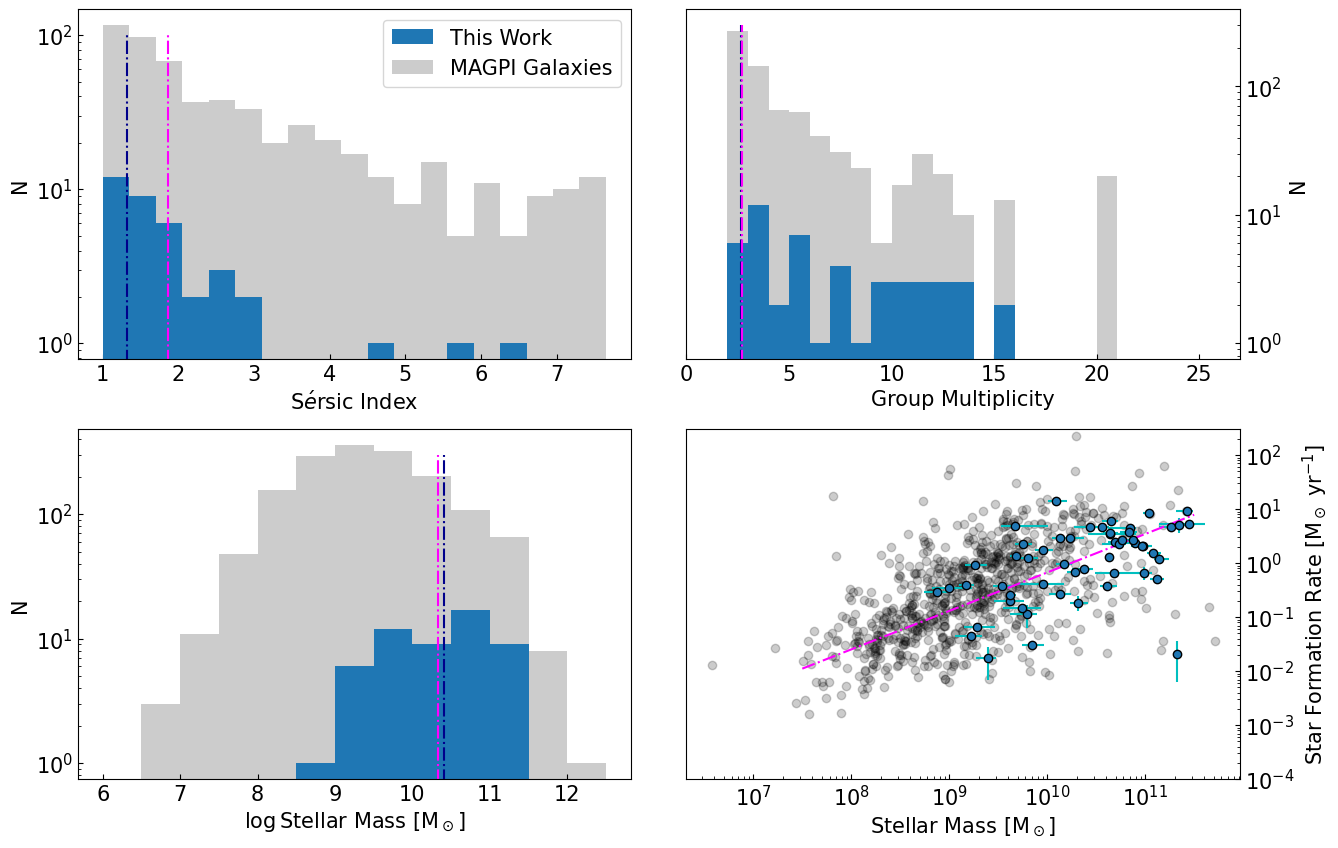

In [253]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2.csv")
print(len(sample))
# sample = sample[sample["v_asym_15_err"]<0.1]
# sample = sample[sample.MAGPIID!=1207197197]
# SFMS & Mass
t = ascii.read("MAGPI_csv/MAGPI_Balmer_SFRs_onedspec.tbl")
df=pd.DataFrame({"MAGPIID":np.array(t['MAGPI_ID']),
                "SFR":np.array(t["SFR"]),
                "SFR_err":np.array(t["SFR_err"])})
df1 = df[df["MAGPIID"].isin(sample["MAGPIID"])]
df2 = df[~df["MAGPIID"].isin(sample["MAGPIID"])]
SFR = df1["SFR"].to_numpy()
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2_BPT.csv")
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
SFR = bpt["SFR"].to_numpy()
SFR_err = df1["SFR_err"].to_numpy()
SFR_2 = df2["SFR"].to_numpy()
SFR[np.isnan(SFR)]=10**(-3.1)
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
M_sol = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_median"].to_numpy()
mass_err_16 = M_sol-prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_16"].to_numpy()
mass_err_84 = prospect[prospect["MAGPIID"].isin(sample["MAGPIID"])]["StellarMass_84"].to_numpy()-M_sol
M_sol_2 = prospect[prospect["MAGPIID"].isin(df2["MAGPIID"].to_numpy())]["StellarMass_median"].to_numpy()
xx = np.logspace(7.5,11.5, len(sample))
MS = (xx**0.712)*(10**-7.293)
# Sersic
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[~galfit["MAGPIID"].isin(sample["MAGPIID"])]
n2 = galfit["n"]
n2 = n2[n2 > 0]
re2 = galfit["re"].to_numpy()
#re2[re2==0]=np.nan
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re2 = (re2/3600)*dl
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
n = galfit["n"]
n = n[n > 0]
re = galfit["re"].to_numpy()
dl = cosmo.luminosity_distance(galfit["z"].to_numpy()).to(u.kpc).value
re = (re/3600)*dl

env = pd.read_csv("MAGPI_csv/kinemetry_sample_env.csv")
n_env = env[~env["MAGPIID"].isin(sample["MAGPIID"])]
env = env[env["MAGPIID"].isin(sample["MAGPIID"])]
n_gals = env['N_Gals'].to_numpy()
n_n_gals = n_env["N_Gals"].to_numpy()

plt.rcParams.update({"font.size":15})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
# Sersic
ax1.hist(n, zorder=2, label="This Work", bins=np.arange(1,8,0.35))
ax1.hist(n2, label="MAGPI Galaxies", color="k", bins=np.arange(1,8,0.35), alpha=0.2)
ax1.vlines(np.median(n), ymin=0, ymax=100,color="darkblue",ls="dashdot")
ax1.vlines(np.mean(n), ymin=0, ymax=100,color="fuchsia",ls="dashdot")
#ax.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylabel("N")
ax1.set_xlabel(r"S$\'{e}$rsic Index")
ax1.legend()
# Environment
ax2.hist(n_gals, label="This Work", zorder=2,bins=np.arange(0,25,1))
#ax2.hist(n_n_gals, zorder=2, label="No Env. Metrics")
ax2.hist(n_n_gals, label="MAGPI Galaxies", color="k", alpha=0.2, zorder=1,bins=np.arange(0,25,1))
ax2.set_yscale("log")
ax2.set_xlabel(r"Group Multiplicity")
ax2.vlines(np.median(np.log10(re)), ymin=0, ymax=300,color="darkblue",linestyles="dashdot")
ax2.vlines(np.mean(np.log10(re)),ymin=0, ymax=300,color="fuchsia",ls="dashdot")
ax2.set_ylabel("N")
#ax2.legend()
ax2.set_xlim(0,27)
# Mass
ax3.hist(np.log10(M_sol), zorder=2, label="Subsample", bins=np.arange(6,13,0.5))
ax3.hist(np.log10(M_sol_2), label="All Galaxies", color="k", bins=np.arange(6,13,0.5), alpha=0.2)
ax3.vlines(np.median(np.log10(M_sol)), ymin=0, ymax=300,color="darkblue",ls="dashdot")
ax3.vlines(np.mean(np.log10(M_sol)), ymin=0, ymax=300,color="fuchsia",ls="dashdot")
ax3.set_ylabel("N")
ax3.set_yscale("log")
ax3.set_xlabel(r"$\log$Stellar Mass [M$_\odot$]")
#ax3.legend()
# SFMS
ax4.scatter(M_sol[SFR>10**(-3)], SFR[SFR>10**(-3)], zorder=3, ec="k")
ax4.scatter(M_sol[SFR<10**(-3)], SFR[SFR<10**(-3)], zorder=3, ec="k",marker="v")
ax4.errorbar(M_sol, SFR, xerr=[mass_err_16,mass_err_84], yerr=SFR_err, zorder=2, fmt=".c", ls="")
ax4.scatter(M_sol_2, SFR_2, zorder=1, alpha=0.2, c="k")
ax4.plot(xx, MS, ls="dashdot", c="magenta")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylim(1e-4, 300)
ax4.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax4.set_ylabel(r"Star Formation Rate [M$_\odot$ yr$^{-1}$]")
for ax in [ax2, ax4]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig("MAGPI_Plots/plots/paper1/SFMS_Mass_Sersic_Env.pdf", bbox_inches="tight")

In [269]:
dex = abs(np.log10(SFR) - np.log10((M_sol**0.712)*(10**-7.293)))
print(len(dex[dex<0.5]))

36


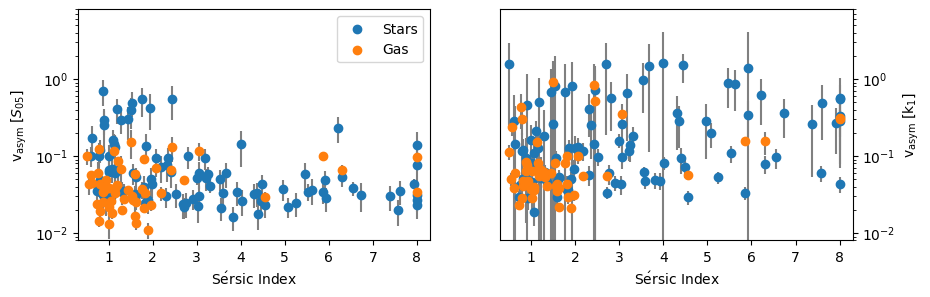

In [6]:
onere = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample.csv")
sample = sample[sample["MAGPIID"].isin(onere["MAGPIID"])]
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
n = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]["n"]
vs_s05 = sample["v_asym_s"].to_numpy()
vs_s05_err=sample["v_asym_s_err"].to_numpy()
vg_s05 = sample["v_asym_g"].to_numpy()
vg_s05_err=sample["v_asym_g_err"].to_numpy()
plt.rcParams.update({"font.size":10})
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].scatter(n,vs_s05,zorder=2,label="Stars")
ax[0].scatter(n,vg_s05,zorder=2,label="Gas")
ax[0].errorbar(n,vs_s05,yerr=vs_s05_err,ls="",color="grey",zorder=1)
ax[0].errorbar(n,vg_s05,yerr=vg_s05_err,ls="",color="grey",zorder=1)
vs_onere = onere["v_asym_s"].to_numpy()
vs_onere_err = onere["v_asym_s_err"].to_numpy()
vg_onere = onere["v_asym_g"].to_numpy()
vg_onere_err = onere["v_asym_g_err"].to_numpy()
n = galfit[galfit["MAGPIID"].isin(onere["MAGPIID"])]["n"]
ax[1].scatter(n,vs_onere,zorder=3,label="Stars")
ax[1].scatter(n,vg_onere,zorder=3,label="Gas")
ax[1].errorbar(n,vs_onere,yerr=vs_onere_err,ls="",color="grey",zorder=2)
ax[1].errorbar(n,vg_onere,yerr=vg_onere_err,ls="",color="grey",zorder=2)
for axes in ax.flat:
    axes.set_yscale("log")
    axes.set_yscale("log")
    axes.set_ylim(8e-3,8)
    axes.set_xlim(0.3,8.3)
    axes.set_xlabel(r"S$\'{\rm e}$rsic Index")
#ax.set_xlabel(r"S$\'{\rm e}$rsic index")
ax[0].set_ylabel(r"v$_{\rm asym}$ [$S_{05}$]")
ax[1].set_ylabel(r"v$_{\rm asym}$ [k$_1$]")
ax[0].legend()
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
#plt.subplots_adjust(wspace=0)
plt.savefig("MAGPI_Plots/plots/paper2/s05_vs_k1.pdf",
            bbox_inches="tight")

In [ ]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_s05.csv")
# onere = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_1Re.csv")
prospect = pd.read_csv("MAGPI_csv/MAGPI_ProSpectCat_v0.1.csv")
galfit = pd.read_csv("MAGPI_csv/MAGPI_GalfitSersicCat_v0.1.csv")
ssp = pd.read_csv("MAGPI_csv/MAGPI_ApertureSpectra_StellarPops_V1.0_SPV.csv")
bpt = pd.read_csv('MAGPI_csv/MAGPI_kinemetry_sample_BPT.csv')
master = pd.read_csv("MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
prospect = prospect[prospect['MAGPIID'].isin(sample["MAGPIID"])]
galfit = galfit[galfit["MAGPIID"].isin(sample["MAGPIID"])]
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
ssp = ssp[ssp["MAGPIID"].isin(sample["MAGPIID"])]
master = master[master['MAGPIID'].isin(sample["MAGPIID"])]
#sample = sample[sample["MAGPIID"].isin(onere["MAGPIID"])]

vs = sample["v_asym_s"].to_numpy()
vs_err=sample["v_asym_s_err"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vg_err=sample["v_asym_g_err"].to_numpy()
age = ssp["logage_LW_1re"].to_numpy()

vs_err[np.isnan(vs)]=0
vg_err[np.isnan(vg)]=0
vs[np.isnan(vs)]=1e-3
vg[np.isnan(vg)]=1e-3

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,ec="k",zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(10**(-3.2),10**(0.3))
ax.set_ylim(10**(-3.2),10**(0.3))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='k',ls="dashed")
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="k",ls="dashed")
plt.savefig("MAGPI_Plots/plots/paper2/s05_gas_stars.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=age,zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
cbar = plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label=r"$\log$ Age [yr]")
ax.set_xlim(10**(-3.2),10**(0.3))
ax.set_ylim(10**(-3.2),10**(0.3))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='magenta')
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="magenta")
#cbar.ax.set_yticklabels([8.95,9.05,9.15,9.25,9.35,9.45,9.55,9.65,9.75])
plt.savefig("MAGPI_Plots/plots/paper2/s05_gas_stars_age.pdf",bbox_inches="tight")

fig,ax=plt.subplots()
p=ax.scatter(vs,vg,c=galfit["n"],vmin=0.9,vmax=5.1,zorder=2)
ax.errorbar(vs,vg,xerr=vs_err,yerr=vg_err,color="grey",ls='',zorder=1)
ax.plot(np.logspace(-3.2,0.7),np.logspace(-3.2,0.7),ls="dashdot",color="k")
ax.set_xlabel(r"$v_{asym}$ [Stars]")
ax.set_ylabel(r"$v_{asym}$ [Gas]")
ax.set_xscale("log")
ax.set_yscale("log")
plt.colorbar(p,ax=ax,fraction=0.05,pad=0.00,label="Sersic")
ax.set_xlim(10**(-3.2),10**(0.7))
ax.set_ylim(10**(-3.2),10**(0.7))
ax.vlines(x=np.std(vs[vs>2e-3]),ymin=10**(-3.2),ymax=np.std(vg[vg>2e-3]),color='magenta')
ax.hlines(y=np.std(vg[vg>2e-3]),xmin=10**(-3.2),xmax=np.std(vs[vs>2e-3]),color="magenta")
plt.savefig("MAGPI_Plots/plots/paper2/s05_gas_stars_sersic.pdf",bbox_inches="tight")

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(10**(age[vs>2e-3]),vs[vs>2e-3],zorder=2)
ax1.errorbar(10**(age[vs>2e-3]),vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(10**(age[vs<2e-3]),vs[vs<2e-3],zorder=2)
ax1.errorbar(10**(age[vs<2e-3]),vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(10**(age[vg<2e-3]),vs[vg<2e-3],zorder=2)
ax1.errorbar(10**(age[vg<2e-3]),vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vs>2e-3]),vg[vs>2e-3],zorder=2)
ax2.errorbar(10**(age[vs>2e-3]),vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vs<2e-3]),vg[vs<2e-3],zorder=2)
ax2.errorbar(10**(age[vs<2e-3]),vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(10**(age[vg<2e-3]),vg[vg<2e-3],zorder=2)
ax2.errorbar(10**(age[vg<2e-3]),vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=10**7,xmax=10**12,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=10**7,xmax=10**12,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(10**(7.8),10**(10.2))
    ax.set_ylim(8e-4,1.2)
ax2.set_yscale("log")
ax1.set_xscale("log")
ax2.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"Stellar Age [yr]")
ax2.set_xlabel(r"Stellar Age [yr]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
#plt.subplots_adjust(wspace=0)
plt.savefig("MAGPI_Plots/plots/paper2/asym_vs_age.pdf",bbox_inches="tight")

mass = prospect["StellarMass_median"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,sharey="row",figsize=(12,4))
ax1.scatter(mass[vs>2e-3],vs[vs>2e-3],zorder=2)
ax1.errorbar(mass[vs>2e-3],vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(mass[vs<2e-3],vs[vs<2e-3],zorder=2)
ax1.errorbar(mass[vs<2e-3],vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(mass[vg<2e-3],vs[vg<2e-3],zorder=2)
ax1.errorbar(mass[vg<2e-3],vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vs>2e-3],vg[vs>2e-3],zorder=2)
ax2.errorbar(mass[vs>2e-3],vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vs<2e-3],vg[vs<2e-3],zorder=2)
ax2.errorbar(mass[vs<2e-3],vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(mass[vg<2e-3],vg[vg<2e-3],zorder=2)
ax2.errorbar(mass[vg<2e-3],vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=10**7,xmax=10**13,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=10**7,xmax=10**13,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(10**(8.8),10**(12.4))
    ax.set_ylim(8e-4,1.2)
ax2.set_yscale("log")
ax2.set_xscale("log")
ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax2.set_xlabel(r"Stellar Mass [M$_\odot$]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
#plt.subplots_adjust(wspace=0)
plt.savefig("MAGPI_Plots/plots/paper2/asym_vs_mass.pdf",bbox_inches="tight")

env = pd.read_csv("MAGPI_csv/kinemetry_sample_env.csv")
env = env[env["MAGPIID"].isin(sample["MAGPIID"])]
env_sample = sample[sample["MAGPIID"].isin(env["MAGPIID"])]
vs = env_sample["v_asym_s"].to_numpy()
vs_err=env_sample["v_asym_s_err"].to_numpy()
vg = env_sample["v_asym_g"].to_numpy()
vg_err=env_sample["v_asym_g_err"].to_numpy()
d1 = env["d1,kpc"].to_numpy()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.scatter(d1[vs>2e-3],vs[vs>2e-3],zorder=2)
ax1.errorbar(d1[vs>2e-3],vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax1.scatter(d1[vs<2e-3],vs[vs<2e-3],zorder=2)
ax1.errorbar(d1[vs<2e-3],vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax1.scatter(d1[vg<2e-3],vs[vg<2e-3],zorder=2)
ax1.errorbar(d1[vg<2e-3],vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vs>2e-3],vg[vs>2e-3],zorder=2)
ax2.errorbar(d1[vs>2e-3],vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vs<2e-3],vg[vs<2e-3],zorder=2)
ax2.errorbar(d1[vs<2e-3],vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax2.scatter(d1[vg<2e-3],vg[vg<2e-3],zorder=2)
ax2.errorbar(d1[vg<2e-3],vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax1.hlines(y=np.std(vs[vs>2e-3]),xmin=0,xmax=250,color="magenta")
ax2.hlines(y=np.std(vg[vg>2e-3]),xmin=0,xmax=250,color="magenta")
for ax in [ax1,ax2]:
    ax.set_xlim(0,225)
    ax.set_ylim(8e-4,1.2)
ax2.set_yscale("log")
ax1.set_yscale("log")
#ax2.set_xscale("log")
#ax1.set_xscale("log")
ax1.set_title("Stars")
ax2.set_title("Gas")
ax1.set_ylabel(r"$v_{asym}$")
ax1.set_xlabel(r"$d_1$ [kpc]")
ax2.set_xlabel(r"$d_1$ [kpc]")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
#plt.subplots_adjust(wspace=0)
plt.savefig("MAGPI_Plots/plots/paper2/asym_vs_d1.pdf",bbox_inches="tight")

mass_rat = env["mass_ratio"].to_numpy()
fig,ax = plt.subplots(1,2,figsize=(12,4))
p=ax[0].scatter(d1[vs>2e-3],vs[vs>2e-3],zorder=2,c=np.log10(mass_rat[vs>2e-3]))
ax[0].errorbar(d1[vs>2e-3],vs[vs>2e-3],yerr=vs_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(d1[vs<2e-3],vs[vs<2e-3],zorder=2,c=np.log10(mass_rat[vs<2e-3]))
ax[0].errorbar(d1[vs<2e-3],vs[vs<2e-3],yerr=vs_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[0].scatter(d1[vg<2e-3],vs[vg<2e-3],zorder=2,c=np.log10(mass_rat[vg<2e-3]))
ax[0].errorbar(d1[vg<2e-3],vs[vg<2e-3],yerr=vs_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(d1[vs>2e-3],vg[vs>2e-3],zorder=2,c=np.log10(mass_rat[vs>2e-3]))
ax[1].errorbar(d1[vs>2e-3],vg[vs>2e-3],yerr=vg_err[vs>2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(d1[vs<2e-3],vg[vs<2e-3],zorder=2,c=np.log10(mass_rat[vs<2e-3]))
ax[1].errorbar(d1[vs<2e-3],vg[vs<2e-3],yerr=vg_err[vs<2e-3],ls="",color="grey",zorder=1)
ax[1].scatter(d1[vg<2e-3],vg[vg<2e-3],zorder=2,c=np.log10(mass_rat[vg<2e-3]))
ax[1].errorbar(d1[vg<2e-3],vg[vg<2e-3],yerr=vg_err[vg<2e-3],ls="",color="grey",zorder=1)
ax[0].hlines(y=np.std(vs[vs>2e-3]),xmin=0,xmax=250,color="magenta")
ax[0].hlines(y=np.std(vg[vg>2e-3]),xmin=0,xmax=250,color="magenta")
for axes in ax.flat:
    axes.set_xlim(0,225)
    axes.set_ylim(8e-4,1.2)
ax[1].set_yscale("log")
ax[0].set_yscale("log")
#ax2.set_xscale("log")
#ax1.set_xscale("log")
ax[0].set_title("Stars")
ax[1].set_title("Gas")
ax[0].set_ylabel(r"$v_{asym}$")
ax[0].set_xlabel(r"$d_1$ [kpc]")
ax[1].set_xlabel(r"$d_1$ [kpc]")
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
#plt.subplots_adjust(wspace=0)
plt.colorbar(p,ax=ax,label=r"$\log$ Mass Ratio",aspect=50,location="top")
plt.savefig("MAGPI_Plots/plots/paper2/asym_vs_d1.pdf",bbox_inches="tight")

In [ ]:
vs = sample["v_asym_s"].to_numpy()
vs_err=sample["v_asym_s_err"].to_numpy()
vg = sample["v_asym_g"].to_numpy()
vg_err=sample["v_asym_g_err"].to_numpy()
vs[vs==1e-3]=5e-3
vg[vg==1e-3]=5e-3
xerr = vs_err/((np.log(10)*(vs)))
yerr = vg_err/((np.log(10)*(vg)))
xerr = np.nanmean(xerr)
yerr = np.nanmean(yerr)
plt.rcParams.update({"font.size":15})

fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])
p=ax.scatter(np.log10(vs[(vs>8e-3) & (vg>8e-3)]),np.log10(vg[(vs>8e-3) & (vg>8e-3)]),s=50)
ax.scatter(np.log10(vs[(vs>8e-3) & (vg<8e-3)]),np.log10(vg[(vs>8e-3) & (vg<8e-3)]),s=50)
ax.scatter(np.log10(vs[(vs<8e-3) & (vg>8e-3)]),np.log10(vg[(vs<8e-3) & (vg>8e-3)]),s=50,c="tab:orange")
ax.errorbar(np.log10(5e-3),0,xerr=xerr,yerr=yerr,color="grey",ls="")
ax.plot(np.linspace(-3.3,1),np.linspace(-3.3,1),ls="dashdot",color="k")
ax.set_xlabel(r"$\log$ v$_{asym}$ [Stars]")
ax.text(s="Gas Dominated",x=-2.2,y=-0.35)
ax.text(s="Stellar Dominated",x=-1,y=-2.15)
ax.set_ylabel(r"$\log$ v$_{asym}$ [Gas]")
ax_histx = fig.add_subplot(gs[0,0])
ax_histx.hist(np.log10(vs[vs>8e-3]),histtype="step",bins=np.arange(-2,0.65,0.15),
              label="Detection")
ax_histx.hist(np.log10(vs[vg<8e-3]),histtype="step",bins=np.arange(-2,0.65,0.15),
              label="Non-Detection")
ax_histx.set_xticks([])
ax_histx.legend(bbox_to_anchor=(1.015,1.05))
ax_histy = fig.add_subplot(gs[1,1])
ax_histy.hist(np.log10(vg[vg>8e-3]),histtype="step",orientation="horizontal",
              bins=np.arange(np.log10(3e-3),0.65,0.15))
ax_histy.hist(np.log10(vg[vs<8e-3]),histtype="step",orientation="horizontal",
              bins=np.arange(np.log10(8e-3),0.65,0.15))
ax_histy.set_yticks([])
ax.set_xlim(-2.5,0.2)
ax.set_ylim(-2.5,0.2)
ax_histx.set_xlim(-2.5,0.2)
ax_histy.set_ylim(-2.5,0.2)
plt.savefig("MAGPI_Plots/plots/paper2/asym_s_g.pdf",bbox_inches="tight")

In [235]:
print(len(sample[sample.v_asym_15>sample.v_asym_05]))
print(len(sample[sample.v_asym_15>sample.v_asym_05])/len(sample))
print(binomial_errors(k=len(sample[sample.v_asym_15>sample.v_asym_05]),n=len(sample)))

print(len(sample[(sample.v_asym_15>0.04) & (sample.v_asym_05>0.04)]))
print(len(sample[(sample.v_asym_15>0.04) & (sample.v_asym_05>0.04)])/len(sample))
print(binomial_errors(k=len(sample[(sample.v_asym_15>0.04) & (sample.v_asym_05>0.04)]),n=len(sample)))

25
0.6944444444444444
[[0.08552628]
 [0.06494322]]
17
0.4722222222222222
[[0.07956841]
 [0.08250851]]


In [211]:
ty = bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"].to_numpy()
print(len(sample[ty==0]))
print(len(sample[ty==0])/len(sample))
binomial_errors(k=len(sample[ty!=1]),n=len(sample))

27
0.5094339622641509


array([[0.06889593],
       [0.06545174]])

In [214]:
ty = bpt["type(sf=1, sy=2, ln=3) SII"].to_numpy()
print(len(sample[ty==3]))
print(len(sample[ty==3])/len(sample))
binomial_errors(k=len(sample[ty>1]),n=len(sample))

13
0.24528301886792453


array([[0.05665721],
       [0.069746  ]])

In [42]:
# Functions used in analysis/plotting
def binomial_errors(n, k, c=0.683):
    import scipy.stats.distributions as dist
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    lower   = np.array([k/n - p_lower])
    upper   = np.array([p_upper - k/n])
    # removing negative errorbars
    lower[lower<0]=0
    upper[upper<0]=0
    # print(np.array([lower, upper]).reshape(2,1))
    return np.array([lower, upper]).reshape(2,1)

In [44]:
binomial_errors(k=len(sample[ty!=1]),n=len(sample))

array([[0.05038369],
       [0.06764922]])

In [48]:
len(sample[ty!=1])/len(sample)

0.25925925925925924

In [241]:
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2.csv")
sample = sample[sample["v_asym_15_err"]<0.4]
print(len(sample))
sample = sample[sample.MAGPIID!=1207197197]
sample = sample[sample.MAGPIID!=1527196197]
print(len(sample))
bpt = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2_BPT.csv")
bpt = bpt[bpt["MAGPIID"].isin(sample["MAGPIID"])]
env = pd.read_csv("MAGPI_csv/kinemetry_sample_env.csv")
env_sample = sample[sample['MAGPIID'].isin(env["MAGPIID"])]
env = env[env['MAGPIID'].isin(env_sample["MAGPIID"])]
print(len(env))

37
36
34


In [242]:
ty = bpt["type(sf+AGN=0, sf=1, sy=2, ln=3)"].to_numpy()
print(len(sample[ty==1]))
print(len(sample[ty==1])/len(sample))
binomial_errors(k=len(sample[ty>1]),n=len(sample))

20
0.5555555555555556


array([[0.01829216],
       [0.06541996]])

In [243]:
ty = bpt["type(sf=1, sy=2, ln=3) SII"].to_numpy()
sf_sample = sample[ty!=1]
print(len(sf_sample[sf_sample.v_asym_15<sf_sample.v_asym_05]))
print(len(sf_sample[sf_sample.v_asym_15<sf_sample.v_asym_05])/len(sf_sample))
binomial_errors(k=len(sf_sample[sf_sample.v_asym_15<sf_sample.v_asym_05]),n=len(sample))

print(len(sample[(sample.v_asym_15>0.04) & (sample.v_asym_05>0.04)]))
print(len(sample[(sample.v_asym_15>0.04) & (sample.v_asym_05>0.04)])/len(sample))
binomial_errors(k=len(sample[sample.v_asym_15>sample.v_asym_05]),n=len(sample))

3
0.3333333333333333
17
0.4722222222222222


array([[0.08552628],
       [0.06494322]])

In [245]:
cen = env_sample[env['BCG?'].to_numpy()]
print(len(cen[cen["v_asym_fw"]>0.04]))
print(len(cen))
print(len(cen[cen["v_asym_fw"]>0.04])/len(cen))
sat = env_sample[~env['BCG?'].to_numpy()]
print(len(sat[sat["v_asym_fw"]>0.04]))
print(len(sat))
print(len(sat[sat["v_asym_fw"]>0.04])/len(sat))

7
12
0.5833333333333334
20
22
0.9090909090909091


In [247]:
print(binomial_errors(len(sat),len(sat[sat["v_asym_fw"]>0.04])))

[[0.09947391]
 [0.03062503]]


In [250]:
len(cen[cen.v_asym_15>cen.v_asym_05])/len(cen)

0.75

In [251]:
len(sat[sat.v_asym_15>sat.v_asym_05])/len(sat)

0.6363636363636364

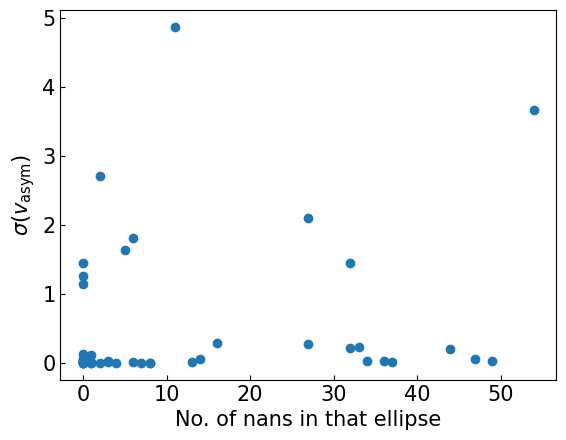

In [305]:
from kinemetry import kinemetry
def clean_images_median(img, pa, a, b, img_err=None,SNR=3):
    y0, x0 = img.shape
    y0, x0 = y0 / 2, x0 / 2
    pa = pa - 90
    pa = np.radians(pa)
    img[0,:] = np.nan
    img[:,0] = np.nan
    for i in range(1,len(img[:, 0])):
        for j in range(1,len(img[0, :])):
            side1 = (((j - x0) * np.cos(pa)) + ((i - y0) * np.sin(pa))) ** 2 / (a ** 2)
            side2 = (((j - x0) * np.sin(pa)) - ((i - y0) * np.cos(pa))) ** 2 / (b ** 2)
            if side1 + side2 > 8:
                img[i, j] = np.nan
            else:
                if img_err is not None and abs(img_err[i, j]) < SNR and i < (len(img[:,0]) - 5) and j < (len(img[0,:])-5) and i > 5 and j > 5:
                    new_img = [img[i-1,j-1],img[i-1,j],img[i-1,j+1],img[i,j-1],img[i,j+1],img[i+1,j-1],img[i+1,j],img[i+1,j+1]]
                    new_img = np.nanmedian(new_img)
                    if np.isnan(new_img):
                        img[i,j]=np.nan
                    else:
                        img[i, j] = new_img
    return img

def clean_images(img, pa, a, b, img_err=None,SNR=3):
    y0, x0 = img.shape
    y0, x0 = y0 / 2, x0 / 2
    pa = pa - 90
    pa = np.radians(pa)
    img[0,:] = np.nan
    img[:,0] = np.nan
    for i in range(1,len(img[:, 0])):
        for j in range(1,len(img[0, :])):
            side1 = (((j - x0) * np.cos(pa)) + ((i - y0) * np.sin(pa))) ** 2 / (a ** 2)
            side2 = (((j - x0) * np.sin(pa)) - ((i - y0) * np.cos(pa))) ** 2 / (b ** 2)
            if side1 + side2 > 8:
                img[i, j] = np.nan
            if img_err is not None and abs(img_err[i, j]) < SNR:
                img[i,j]=np.nan
    return img


os.chdir("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW")
sample = pd.read_csv("MAGPI_csv/MAGPI_kinemetry_sample_M2.csv")
logfile = open("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Plots/log.txt","w")
galaxies = sample["MAGPIID"].to_numpy()
#galaxies = [1204198199]
n_nans = []
vasym_err = []
for g in galaxies:
    galaxy = g
    logfile.write(str(g)+"\n")
    field = str(galaxy)[:4]
    master= pd.read_csv("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_csv/MAGPI_master_source_catalogue.csv",skiprows=16)
    master = master[master["MAGPIID"].isin([galaxy])]
    pa = master["ang_it"].to_numpy()
    q = master["axrat_it"].to_numpy()[0]
    r50 = master['R50_it'].to_numpy()/0.2

    vasyms = sample[sample["MAGPIID"].isin([g])]
    gasfile = fits.open("/Users/ryanbagge/Library/CloudStorage/OneDrive-UNSW/MAGPI_Maps/MAGPI"+field+"/Emission_Line/MAGPI"+str(galaxy)+"_GIST_EmissionLines.fits")
    g_flux, g_flux_err, g_velo, g_velo_err = gasfile[49].data, gasfile[50].data, gasfile[9].data, gasfile[10].data
    gasfile.close()

    g_velo = clean_images(g_velo, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
    g_velo_err = clean_images(g_velo_err, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
    g_flux = clean_images(g_flux, pa, r50, r50 * q, img_err=g_flux / g_flux_err)
    g_flux = g_flux / g_flux_err
    y0,x0 = g_flux.shape
    y0,x0 = y0/2,x0/2

    start = (0.65 / 2) / 0.2
    step = (0.65 / 2) / 0.2
    end = 2 * r50
    rad = np.arange(start, end, step)

    kg = kinemetry(img=g_velo, x0=x0, y0=y0, ntrm=11, plot=False, verbose=False, radius=rad,
                           bmodel=True, rangePA=[0, 360], rangeQ=[q - 0.1, q + 0.1], allterms=True)
    zeros_kg = np.where(kg.eccano==0)[0]
    zeros_kg = zeros_kg[1:]
    x = zeros_kg[(rad/r50)<1.5][-1]
    y = zeros_kg[(rad/r50)<1.5][-2]
    v_ellip_nans = kg.ex_mom[y:x][np.isnan(kg.ex_mom[y:x])]
    n_nans.append(len(v_ellip_nans))
    vasym_err.append(vasyms["v_asym_15_err"].to_numpy()[0])

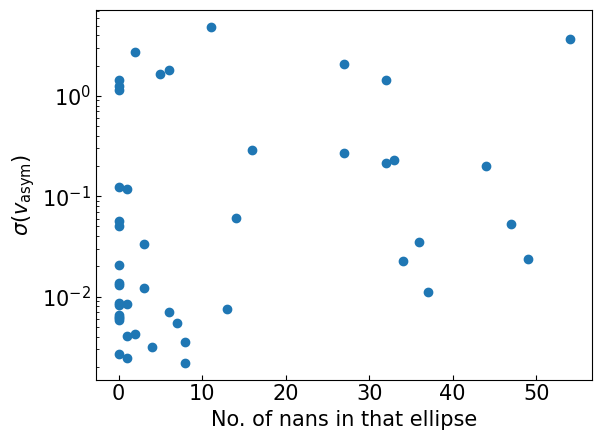

In [309]:
fig,ax = plt.subplots()
ax.scatter(n_nans,vasym_err)
ax.set_ylabel(r"$\sigma (v_{\rm asym})$")
ax.set_xlabel("No. of nans in that ellipse")
ax.set_yscale("log")
#ax.set_xscale("log")
plt.show()

In [307]:
n_nans

[0,
 6,
 0,
 0,
 19,
 8,
 0,
 1,
 0,
 16,
 0,
 37,
 3,
 11,
 2,
 4,
 44,
 47,
 0,
 0,
 0,
 54,
 32,
 0,
 0,
 0,
 24,
 0,
 9,
 49,
 8,
 32,
 27,
 29,
 7,
 0,
 14,
 1,
 2,
 1,
 5,
 36,
 1,
 0,
 34,
 27,
 76,
 6,
 0,
 13,
 3,
 0,
 33,
 32]